## Import data

In [2]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np
import scipy
from tqdm import tqdm

In [3]:

with open('./data-challenge-kernel-methods-2022-2023/test_data.pkl', 'rb') as f:
    challenge_data = pickle.load(f)
    
with open('./data-challenge-kernel-methods-2022-2023/training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
with open('./data-challenge-kernel-methods-2022-2023/training_labels.pkl', 'rb') as f:
    train_label = pickle.load(f)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=42)

In [5]:
def visualize_graph(graph, label):
    my_pos = nx.spring_layout(graph, seed = 1032023)
    print(f'Graph with label: {label}')

    labels_nodes = {key:value[0] 
                    for (key,value) 
                    in nx.get_node_attributes(graph, 'labels').items()}
    
    labels_edges = {key:value[0] 
                    for (key,value) 
                    in nx.get_edge_attributes(graph, 'labels').items()}
    
    nx.draw(graph, pos = my_pos,labels =labels_nodes, with_labels=True, node_size=500)

    nx.draw_networkx_edge_labels(graph, my_pos, edge_labels=labels_edges, font_color='red')
    
    plt.show()
 

## 1. Implementing Walk Kernels

The product graph needed for the Random walk kernel is the so-called 'Tensir product of graph' or 'Direct product'. Consider G,H graphs and GxH the product. 

This graph has the property that the adjancecy matrix is the Kronecker (tensor) product of the adjacency matrices of G and H (with a possible transformation). (wikipedia).

Assume A has n nodes and B has m nodes, the adjacency matrix of $A\times B$ will have nm nodes. Enumerating the nodes of $A\times B$ as 1=(A1,B1), 2=(A1,B2),..., m = (A1,Bm)... we dont need to further transform the adjacency matrix, it will just be the Kronecker product. 

Then, node k of $A\times B$ will correspond to k=(A{(k-(k%m))/m}, B{k%m}) or k=(A{(k-(k%m))/m}, B{m}) if k%m=0.

Since our data is labeled, we will then remove the nodes where the label of the corresponding nodes in G and H do not have the same label.



### 1.1. Implementing graph product

In [6]:
import networkx as nx 
import numpy as np
import scipy

class ProductGraph:
    '''
    Direct product graph. 
    Functions in this version take adjacency matrices and dictionaries with labels objects.
    
    Contains two functions, one for labeled nodes and one for unlabeled nodes.
    They allow to return a graph object or the adjacency matrix.
    It's the version needed for the random walk kernel.
    
    '''
    def __init__(self):
        pass
        
    def labeled_nodes(self,G1, G2, return_nx = False):
        '''
        Direct product graph (aka Tensor Product of Graph).
        Assumes graphs have attribute 'labels' for each node.
        Also assumes nodes in the graphs are numbered starting from 0.
        These properties appear to be true in our dataset.
        Does not take into account labeled edges.
        
        Will return only adjacency matrix of the product by default. 
        
        If return_nx is True, a networkx object with labeled nodes will be returned
        
        _Parameters_
        :param adj_G1, adj_G2: adjacency matrices 
        :param labels_1,  labels_2: dictionaries with the numbers of the nodes and the labels 
        '''

        #obtain adjacency matrix and dictionaries with labels from graphs
        adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix 
        labels_1 = nx.get_node_attributes(G1, 'labels')

        adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix 
        labels_2 = nx.get_node_attributes(G2, 'labels')
            
        n = adj_G1.shape[0]

        m = adj_G2.shape[0]

        adj_prod = scipy.sparse.kron(adj_G1,adj_G2,format='csr') #adjacency matrix of the simple product graph
         # create graph from adjacency matrix

        k = adj_prod.shape[0]
        
        if k==0:
            return np.empty(0) 
        if return_nx:
            #Here we want to put the label in the product graph, so we take advantage of
            #the structure of the nx graph object
            prodG = nx.from_scipy_sparse_array(adj_prod)
            for i in range(1, k+1):
                #Corresponding nodes in G1 and G2 to node i in the product
                node_1 =  (i-(i%m))/m +1 if i%m!=0 else (i-(i%m))/m 
                node_2 = i%m if i%m!=0 else m

                #Remove node in product if labels are different, set label otherwise
                if labels_1[node_1-1]!=labels_2[node_2-1]:
                    prodG.remove_node(i-1)
                else:
                    nx.set_node_attributes(prodG, {i-1:labels_1[node_1-1]}, 'labels')
            return prodG
        
        else: 
            #We try to work only with matrices to work more efficiently.
            # However going from matrix to sparse and/or viceversa might be costly
            
            #I checked and this is faster than dealing with the networkx graph and the retreiving its adjacency matrix
            
            nodes_to_remove =[]
            for i in range(1, k+1):
                #Corresponding nodes in G1 and G2 to node i in the product
                node_1 =  (i-(i%m))/m +1 if i%m!=0 else (i-(i%m))/m 
                node_2 = i%m if i%m!=0 else m

                #Remove node in product if labels are different, set label otherwise
                if labels_1[node_1-1]!=labels_2[node_2-1]:
                    nodes_to_remove.append(i-1)
                    
            adj_prod = adj_prod.toarray()
            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 0)
            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 1)
            
            return adj_prod

            
    def unlabeled(self,G1,G2,return_nx = False):
        '''
        Direct product graph (aka Tensor Product of Graph).
        
        Here we do not take into account the labels of the graph.
        
        It returns the adjacency matrix of the product.
        ! It is a scipy sparse matrix
        '''

        #obtain adjacency matrix from graphs
        adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix 
        adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix 
  
        adj_prod = scipy.sparse.kron(adj_G1,adj_G2) #adjacency matrix of the simple product graph
        
        if return_nx:
            return nx.from_scipy_sparse_array(adj_prod)
        else:
            return adj_prod
        
        
    def labeled_edges(self,G1, G2, return_nx = False):
        '''
        Direct product graph (aka Tensor Product of Graph) taking into account labeled
        nodes and edges.
        Assumes graphs have attribute 'labels' for each node and for each edge.
        Also assumes nodes in the graphs are numbered starting from 0.
        These properties appear to be true in our dataset.

        Will return only adjacency matrix of the product by default. 
        
        If return_nx is True, a networkx object with labeled nodes will be returned
        
        _Parameters_
        :param adj_G1, adj_G2: adjacency matrices 
        :param labels_1,  labels_2: dictionaries with the numbers of the nodes and the labels 
        '''

        #obtain adjacency matrix and dictionaries with labels from graphs
        adj_G1 = nx.adjacency_matrix(G1)
        adj_G2 = nx.adjacency_matrix(G2)
        node_labels_1 = nx.get_node_attributes(G1, 'labels')
        node_labels_2 = nx.get_node_attributes(G2, 'labels')
        
        n = adj_G1.shape[0]

        m = adj_G2.shape[0]

        
        adj_prod = scipy.sparse.kron(adj_G1,adj_G2,format='csr')
        
        # TODO We have to deal with labeled nodes returning 0
                
        if return_nx:
            prod =  self.labeled_nodes(G1, G2, return_nx = True)

            # TODO We have to deal with labeled nodes returning 0
            
            to_remove = []

            for edge in prod.edges(data=True):
                #Corresponding nodes in G1 and G2 to node i in the product
                start = edge[0]+1
                end = edge[1]+1
                start_1 =  (start-(start%m))/m +1 if start%m!=0 else (start-(start%m))/m 
                start_2 = start%m if start%m!=0 else m
                end_1 =  (end-(end%m))/m +1 if end%m!=0 else (end-(end%m))/m 
                end_2 = end%m if end%m!=0 else m

                #print('p', start,end)
                #print('G1', start_1, end_1)
                #print('G2', start_2, end_2)

                label_1 = G1.get_edge_data(start_1-1, end_1-1)['labels']
                label_2 = G2.get_edge_data(start_2-1, end_2-1)['labels']

                #Remove node in product if labels are different, set label otherwise
                if label_1!=label_2:
                    to_remove.append((start-1, end-1))
                else:
                    nx.set_edge_attributes(prod, {(start-1, end-1):label_1}, 'labels')

            prod.remove_edges_from(to_remove)
            #prod.remove_nodes_from(list(nx.isolates(prod)))

            return prod #non sparse matrix

        else: 
            edges_to_remove = []
            nodes_to_remove =[]

            cx = adj_prod.tocoo()
            
            for start,end in zip(cx.row, cx.col):
                start +=1
                end +=1
                start_1 =  (start-(start%m))/m +1 if start%m!=0 else (start-(start%m))/m 
                start_2 = start%m if start%m!=0 else m
                end_1 =  (end-(end%m))/m +1 if end%m!=0 else (end-(end%m))/m 
                end_2 = end%m if end%m!=0 else m

                label_1 = G1.get_edge_data(start_1-1, end_1-1)['labels']
                label_2 = G2.get_edge_data(start_2-1, end_2-1)['labels']

                #Remove node in product if labels are different, set label otherwise
                if label_1!=label_2:
                    edges_to_remove.append((start-1, end-1))

                if node_labels_1[start_1-1]!=node_labels_2[start_2-1]:
                    nodes_to_remove.append(start-1)

                if node_labels_1[end_1-1]!=node_labels_2[end_2-1]:
                    nodes_to_remove.append(end-1)

            adj_prod = adj_prod.toarray()

            for edge in edges_to_remove:
                adj_prod[edge[0],edge[1]]=0
                adj_prod[edge[1],edge[0]]=0

            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 0)
            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 1)

            return adj_prod

Graph with label: 0


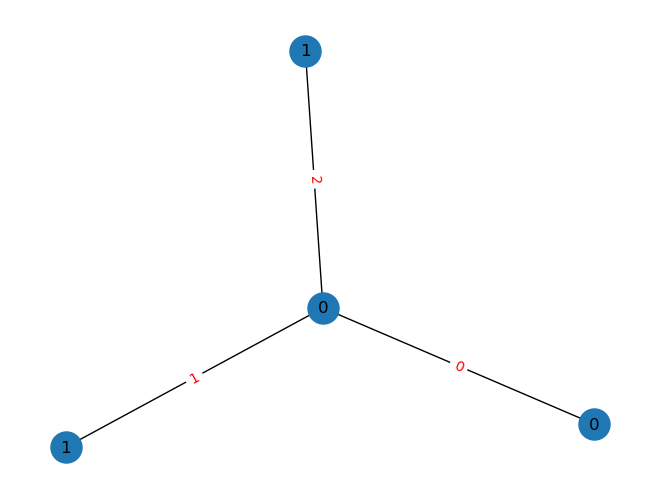

Graph with label: 0


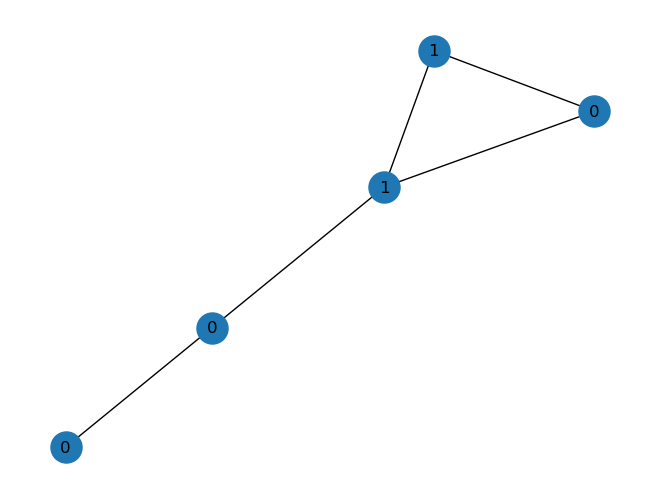

In [7]:
A = nx.Graph()
A.add_nodes_from([(0, {'labels': [0]}),
                 (1, {'labels': [0]}),
                 (2, {'labels': [1]}),
                 (3, {'labels': [1]})])

A.add_edges_from([(0, 1,{'labels': [0]}),
                  (1, 2,{'labels': [1]}),
                  (1, 3,{'labels': [2]})])

B = nx.Graph()
B.add_nodes_from([(0, {'labels': [0]}),
                 (1, {'labels': [0]}),
                 (2, {'labels': [1]}),
                 (3, {'labels': [0]}),
                 (4, {'labels': [1]})])
B.add_edge(0, 1)
B.add_edge(1, 2)
B.add_edge(2, 3)
B.add_edge(2, 4)
B.add_edge(4, 3)

visualize_graph(A, y_train[0])
visualize_graph(B, y_train[0])


[(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (5, {}), (6, {}), (7, {}), (8, {}), (9, {})]
Graph with label: 0


/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26478/441211579.py:36: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26478/441211579.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix


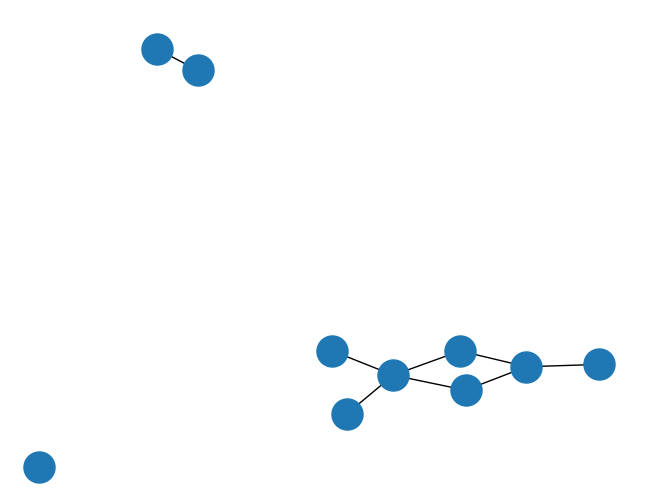

In [10]:
#prod =  ProductGraph_V2.labeled_nodes(A, B, return_nx=True)
prod = nx.from_numpy_array(ProductGraph().labeled_nodes(A, B, return_nx=False))
print(list(prod.nodes(data=True)))
visualize_graph(prod, y_train[0])


Graph with label: 0


/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26478/441211579.py:36: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26478/441211579.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix


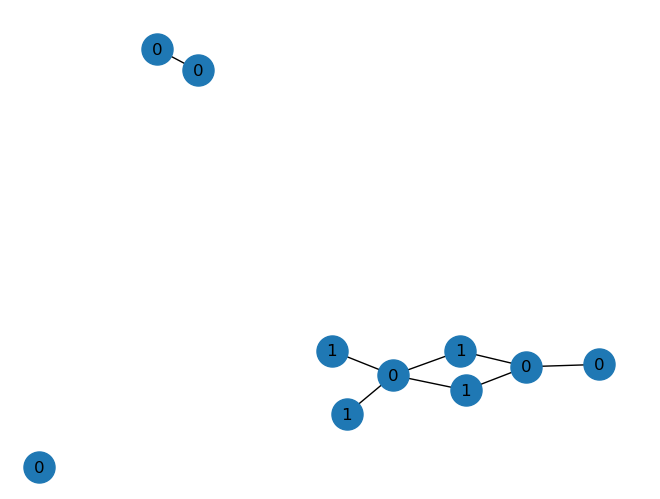

In [12]:
prod = ProductGraph().labeled_nodes(A, B, return_nx=True)
visualize_graph(prod, y_train[0])


### 1.. n-th order walk kernel

In [13]:
class nth_Walk_Kernel:
    def __init__(self,n = 5, product = ProductGraph().labeled_nodes):
        self.product = product
        self.n = n
    
    def kernel_pairwise(self,G1,G2):
        '''
        Computes kernel function for 2 graphs
        '''
        
        adj_prod = self.product(G1,G2)
        k = adj_prod.shape[0]
                
        if k!=0:
            if isinstance(adj_prod, np.ndarray): power = np.linalg.matrix_power(adj_prod, self.n)
            else: power = adj_prod.power(self.n)
            ones = np.ones(k)
            output = (ones.T@power@ones)
        else : output = 0 #in this case the matrices have no vertices in common
        
        return  output
    
    def kernel_matrix(self, G):
        '''
        Computes kernel matrix for a list of graphs.
        
        '''
        n = len(G)
        
        K = np.zeros((n,n))
        
        print('Computing Kernel Matrix')
        for i in tqdm(range(n)):
            for j in range(i,n):
                K[i][j] = self.kernel_pairwise(G[i], G[j])
                if i!=j:
                    K[j][i]= K[i][j]

        return K
    
    def kernel(self,G1,G2):
        '''
        Computes pairwise kernel comparisons between two lists of graphs.
        '''
        n = len(G1)
        m = len(G2)
        K = np.zeros((n,m))
        
        
        for i in range(n):
            for j in range(m):
                K[i][j] = self.kernel_pairwise(G1[i], G2[j])
                    
        return K

## 2. Implementing Support Vector Machine

In [17]:
from cvxopt import solvers
from cvxopt import matrix
from datetime import datetime
from sklearn.metrics import accuracy_score
from scipy import optimize


In [18]:
class KernelSVC:
    '''
    Suport vector machine classifier from homework 2 with a few modifications so it works with the kernel class we have defined for the
    random walk kernel. 
    We change the optimizer to use one specifically for quadratic programming convex problems from the cvxopt library.
    I also added a precomputed_K parameter, so if you run the fit function for some data, before rerruning for, for example a
    different value of C, you can save the kernel matrix that is saved in the attribure K, and save time. 
    '''
    
    def __init__(self, C, kernel, precomputed_K = np.array([]), epsilon = 1e-5, optimizer = 'qp'):
        self.type = 'non-linear'
        self.optimizer = optimizer
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
        self.support_coefs = None
        self.K = precomputed_K
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        
        if self.K.shape[0]==0:
            self.K = self.kernel.kernel_matrix(X)
        
        
        diag_y = np.diag(y)
        P = diag_y.T @ self.K @ diag_y
        q = - np.ones(N).astype(np.double)
        G = np.vstack((np.identity(N),  -np.identity(N))).astype(np.double)
        h = np.hstack((self.C*np.ones((N)),np.zeros((N)))).astype(np.double)
        A = y.reshape(1,N).astype(np.double)
        #print('rank A',np.linalg.matrix_rank(A) )
        b = np.zeros((1,1), np.double)
        #print('Rank([P; A; G]) ',np.linalg.matrix_rank(np.concatenate((P,A,G))) )
        
        print('Begin optimizing')
        if self.optimizer =='qp':
            optRes = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b), kktsolver = 'chol')
            self.alpha = np.asarray(optRes['x']).reshape(N)
            
        elif self.optimizer == 'np':
            # Lagrange dual problem
            def loss(alpha):
                return (1/2)*(alpha@P)@alpha.T + alpha@q.T #dual Loss

            # Partial derivate of Ld on alpha
            def grad_loss(alpha):
                grad = P@alpha + q
                return grad 

            fun_eq = lambda alpha: (A@alpha).reshape(1,1)      
            jac_eq = lambda alpha: y
            fun_ineq = lambda alpha: -(G@alpha - h).reshape(2*N,1)       
            jac_ineq = lambda alpha: -G  

            constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                           {'type': 'ineq', 
                            'fun': fun_ineq , 
                            'jac': jac_ineq})

            optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                       x0=np.ones(N), 
                                       method='SLSQP', 
                                       jac=lambda alpha: grad_loss(alpha), 
                                       constraints=constraints)
            self.alpha = optRes.x
        
            
        print('alpha', self.alpha)
        ## Assign the required attributes
        
   
        #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------''       
        #Points that lay in te margin are also those s.t. 0<alpha_i<C
        indices_on_margin = np.asarray((self.alpha>self.epsilon) & (self.alpha<self.C)).nonzero()[0]
        self.margin_points =  [X[l] for l in indices_on_margin]
        
         #''' -----------------offset of the classifier------------------ '''
        #Obtain supporting vectors and their corresponding coefficient for f
        sv_indices = np.asarray((self.alpha>self.epsilon)).nonzero()[0]
        self.support = [X[l] for l in sv_indices]
        self.support_coefs = np.multiply(self.alpha[sv_indices], y[sv_indices])
    
                         
        #Compute b as the average of b obtained by points in margin                 
        self.b = np.mean((y[indices_on_margin]-self.separating_function_K(indices_on_margin, sv_indices)))
        
        
        # '''------------------------RKHS norm of the function f ------------------------------'''          
        #self.norm_f = (self.alpha.T@ self.K)@self.alpha

        
    def separating_function_K(self,indices_on_margin, sv_indices):
        '''
        Computes the separating function in the specific points needed to compute the offset b.
        It uses the kernel matrix on the data instead od recomputing the kernel in these points.
        
        '''
        print('Computing Separating Function on margin')
        K = np.asarray([[self.K[i][j] for i in list(sv_indices)] for j in list(indices_on_margin)])
        
        print('indices_on_margin', len(indices_on_margin))
        print('K', K.shape)
        print('self.support_coefs', self.support_coefs.shape)
        
        return  K @self.support_coefs
    
    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N

        K = self.kernel.kernel(self.support,x)
        return  self.support_coefs @ K
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        #print('d',d)
        return np.sign(d+self.b)
    